# 📊 Olist Customer 360 Analysis

This notebook develops a full **Customer 360 intelligence model** using the Olist e-commerce dataset from Brazil.  
It demonstrates how raw transactional data can be converted into **customer understanding, predictive insights, and actionable recommendations**.

---

## 🔍 What this analysis covers

### **1. Customer Lifecycle Metrics (RFM)**
- Recency (days since last purchase)  
- Frequency (number of orders)  
- Monetary value (total spend)  

### **2. Churn Identification**
- Uses **future-purchase logic** instead of arbitrary cutoffs  
- Creates a reliable label for predicting customer attrition  

### **3. Customer Segmentation**
- KMeans clustering  
- Behavioral segmentation based on RFM + review score + freight ratio  

### **4. Churn Modelling**
- Random Forest classifier  
- AUC evaluation and probability distribution  
- Feature importance insights  

### **5. Next-Best-Offer (NBO)**
- Market Basket Analysis (Apriori rules)  
- Cross-sell patterns at SKU and category level  

---

## 🎯 Project Goal
To build an end-to-end customer intelligence workflow that covers **segmentation, prediction, and recommendation**, useful for **retention analysts, CRM teams, and marketing decision-makers**.

---



In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# ============================================================
# 📦 1. LIBRARIES & GLOBAL CONFIG
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

sns.set(style="whitegrid")
pd.options.display.float_format = '{:.2f}'.format

# ============================================================
# 📥 2. LOAD RAW OLIST DATASETS (Google Drive Paths)
# ============================================================

customers = pd.read_csv('/content/drive/MyDrive/olist_customers_dataset.csv')
orders = pd.read_csv('/content/drive/MyDrive/olist_orders_dataset.csv')
order_items = pd.read_csv('/content/drive/MyDrive/olist_order_items_dataset.csv')
payments = pd.read_csv('/content/drive/MyDrive/olist_order_payments_dataset.csv')
reviews = pd.read_csv('/content/drive/MyDrive/olist_order_reviews_dataset.csv')
products = pd.read_csv('/content/drive/MyDrive/olist_products_dataset.csv')

# ============================================================
# 🗓 3. DATE PARSING
# ============================================================

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])

# quick confirmation
orders[['order_purchase_timestamp', 'order_delivered_customer_date']].head()


,order_purchase_timestamp,order_delivered_customer_date
0,2017-10-02 10:56:33,2017-10-10 21:25:13
1,2018-07-24 20:41:37,2018-08-07 15:27:45
2,2018-08-08 08:38:49,2018-08-17 18:06:29
3,2017-11-18 19:28:06,2017-12-02 00:28:42
4,2018-02-13 21:18:39,2018-02-16 18:17:02


In [33]:
# ============================================================
# 🧩 4. BUILD MASTER DATAFRAME (ORDERS + CUSTOMERS + ITEMS + PAYMENTS + REVIEWS)
# ============================================================

# 1) Merge customers into orders
df = (
    orders
    .merge(customers, on='customer_id', how='left')
)

# 2) Add order-item level info (price, freight, product)
df = df.merge(
    order_items[['order_id', 'product_id', 'price', 'freight_value']],
    on='order_id',
    how='left'
)

# 3) Add payment info
df = df.merge(
    payments[['order_id', 'payment_value']],
    on='order_id',
    how='left'
)

# 4) Add review scores
df = df.merge(
    reviews[['order_id', 'review_score']],
    on='order_id',
    how='left'
)

# 5) Add product metadata (category names)
df = df.merge(
    products[['product_id', 'product_category_name']],
    on='product_id',
    how='left'
)

# Quick preview of merged dataset
df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_id,price,freight_value,payment_value,review_score,product_category_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,87285b34884572647811a353c7ac498a,29.99,8.72,18.12,4.00,utilidades_domesticas
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,87285b34884572647811a353c7ac498a,29.99,8.72,2.00,4.00,utilidades_domesticas
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,87285b34884572647811a353c7ac498a,29.99,8.72,18.59,4.00,utilidades_domesticas
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,141.46,4.00,perfumaria
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,aa4383b373c6aca5d8797843e5594415,159.90,19.22,179.12,5.00,automotivo


### 🧩 Building the Master Table

To enable full Customer 360 analysis, we construct a unified dataset by merging:

- **orders** → transaction-level details  
- **customers** → customer metadata (location, unique ID)  
- **order_items** → item-level spend & freight  
- **payments** → payment value  
- **reviews** → satisfaction signal  
- **products** → category metadata  

This gives us a single source of truth to calculate RFM, churn, LTV, basket behavior, etc.

In [34]:
# ============================================================
# 🔥 5. DEFINE CHURN WINDOW (Who Returned After X Days?)
# ============================================================

# Business assumption:
# If a customer does NOT place an order within <churn_window_days>,
# they are considered churned.

churn_window_days = 90

# Determine cutoff
max_date = df['order_purchase_timestamp'].max()
cutoff_date = max_date - pd.Timedelta(days=churn_window_days)

print(f"🕒 Max purchase timestamp   : {max_date}")
print(f"⛔ Churn cutoff (no orders after): {cutoff_date}")

# Split observation & future periods
df_obs = df[df['order_purchase_timestamp'] <= cutoff_date].copy()    # used to compute RFM + features
df_future = df[df['order_purchase_timestamp'] > cutoff_date].copy()  # used to check return behaviour


🕒 Max purchase timestamp   : 2018-10-17 17:30:18
⛔ Churn cutoff (no orders after): 2018-07-19 17:30:18


### 🔥 Defining the Churn Window

Churn in e-commerce is typically defined using *time since last purchase*.  
Here we define:

- **Observation window** → customer behavior up to a chosen cutoff date  
- **Future window** → check if they returned after that cutoff  

A customer is considered **churned** if they do *not* place any order within the next **90 days**.

This approach aligns with the industry practice for calculating *inactivity-based churn*.


### 🔍 Customer-Level Feature Engineering (RFM + Behavioral Signals)

To profile customers meaningfully, we aggregate all transactional activity
within the **observation window**. For each unique customer, we compute:

- **Total Orders**  
- **Total Spend**  
- **Average Order Value**  
- **Recency (days since last purchase before cutoff)**  
- **Average Review Score**  
- **Freight-to-Spend Ratio**  
- **Low Reviewer Flag** (customers giving consistently low review scores)

These features are later used for segmentation, churn modeling and customer value prediction.


In [35]:
# ============================================================
# 6. CUSTOMER-LEVEL FEATURE ENGINEERING
# ============================================================

# Last observed purchase date per customer
last_order = df_obs.groupby('customer_unique_id')['order_purchase_timestamp'].max()

# Core aggregations
cust_agg = df_obs.groupby('customer_unique_id').agg({
    'order_id': 'nunique',
    'price': 'sum',
    'freight_value': 'sum',
    'review_score': 'mean',
    'payment_value': 'sum',
})

cust_agg.columns = [
    'total_orders',
    'total_spend',
    'total_freight',
    'avg_review_score',
    'total_payment_value'
]

# ==========================
# Recency relative to cutoff
# ==========================
cust_agg['recency_days'] = (cutoff_date - last_order).dt.days

# ==========================
# RFM-style & behavioural features
# ==========================
cust_agg['frequency'] = cust_agg['total_orders']                  # RFM F
cust_agg['monetary'] = cust_agg['total_spend']                    # RFM M
cust_agg['avg_order_value'] = cust_agg['total_spend'] / cust_agg['total_orders']
cust_agg['freight_ratio'] = cust_agg['total_freight'] / cust_agg['total_spend']

# customers who give low average review scores (<=3)
cust_agg['is_low_reviewer'] = (cust_agg['avg_review_score'] <= 3).astype(int)

# ==========================
# Handle missing & infinite values
# ==========================
cust_agg = cust_agg.replace([np.inf, -np.inf], np.nan).fillna(0)

cust_agg.head()


,total_orders,total_spend,total_freight,avg_review_score,total_payment_value,recency_days,frequency,monetary,avg_order_value,freight_ratio,is_low_reviewer
customer_unique_id,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,12.00,5.00,141.90,70,1,129.90,129.90,0.09,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,8.29,4.00,27.19,73,1,18.90,18.90,0.44,0
0000f46a3911fa3c0805444483337064,1,69.00,17.22,3.00,86.22,495,1,69.00,69.00,0.25,1
0000f6ccb0745a6a4b88665a16c9f078,1,25.99,17.63,4.00,43.62,279,1,25.99,25.99,0.68,0
0004aac84e0df4da2b147fca70cf8255,1,180.00,16.89,5.00,196.89,246,1,180.00,180.00,0.09,0


### 🔥 Defining Customer Churn Using the Observation–Prediction Split

Instead of picking an arbitrary recency threshold, we define churn using a
data-driven approach:

- The dataset is split using the **80th percentile** of purchase timestamps.
    - **Observation Window**: First 80% of time
    - **Future Window**: Remaining 20%
- A customer is marked **churned = 1** if:
    - They made NO purchases in the future window.
- This method mirrors real-world churn prediction pipelines where future
  behaviour is treated as ground truth.

The output of this step is the binary label needed for supervised churn modeling.


In [36]:
# ============================================================
# 7. CHURN DEFINITION (Observation → Future Split)
# ============================================================

# 80th percentile time split
cutoff = df['order_purchase_timestamp'].quantile(0.80)

df_obs = df[df['order_purchase_timestamp'] <= cutoff].copy()
df_future = df[df['order_purchase_timestamp'] > cutoff].copy()

# Latest observed purchase per customer
last_obs = df_obs.groupby('customer_unique_id')['order_purchase_timestamp'].max()

# First future purchase (if any)
first_future = df_future.groupby('customer_unique_id')['order_purchase_timestamp'].min()

# Build churn label table
churn_df = pd.DataFrame({
    'last_obs_order': last_obs,
    'first_future_order': first_future
})

# churn = no future purchase
churn_df['churned'] = churn_df['first_future_order'].isna().astype(int)

# Remove older churn column if it exists
cust_agg = cust_agg.drop(columns=['churned'], errors='ignore')

# Assign churn label
cust_agg = cust_agg.join(churn_df['churned'], how='left')
cust_agg['churned'] = cust_agg['churned'].fillna(1).astype(int)

cust_agg.head()


,total_orders,total_spend,total_freight,avg_review_score,total_payment_value,recency_days,frequency,monetary,avg_order_value,freight_ratio,is_low_reviewer,churned
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,12.00,5.00,141.90,70,1,129.90,129.90,0.09,0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,8.29,4.00,27.19,73,1,18.90,18.90,0.44,0,1
0000f46a3911fa3c0805444483337064,1,69.00,17.22,3.00,86.22,495,1,69.00,69.00,0.25,1,1
0000f6ccb0745a6a4b88665a16c9f078,1,25.99,17.63,4.00,43.62,279,1,25.99,25.99,0.68,0,1
0004aac84e0df4da2b147fca70cf8255,1,180.00,16.89,5.00,196.89,246,1,180.00,180.00,0.09,0,1


### 🔍 Churn Distribution Check

After defining churn using the 80–20 temporal split, it is normal for churn
to be heavily imbalanced. The Olist dataset spans multiple years, but most
customers make only one or two purchases overall. When the future window
covers the final 20% of time, the majority of customers simply do not return,
making them valid churn cases.

This imbalance is realistic and expected in e-commerce customer behaviour.  
We will handle it in the modeling stage using:
- class_weight = "balanced"  
- ROC/AUC instead of accuracy  
- probability-based insights rather than raw labels  


In [37]:
cust_agg['churned'].value_counts(normalize=True)


,proportion
churned,
1,0.88
0,0.12


### 🎯 Customer Segmentation (K-Means)

To understand behavioural patterns across the customer base, we applied K-Means
clustering on six customer-level features:

- Recency (days since last purchase)
- Frequency (total orders)
- Monetary (total spend — log-transformed)
- Avg Order Value (log-transformed)
- Freight Ratio (freight / spend)
- Average Review Score

Because spend-based variables are heavily skewed in e-commerce datasets,
monetary fields were log-transformed prior to scaling. All features were then
standardized to prevent any single metric from dominating the distance measure.

#### 📌 Choosing the number of clusters
We tested cluster sizes from k=2 to k=7 using the Silhouette Score:

- Best result: **k = 4**
- Silhouette score: **~0.29**

While not extremely high (e-commerce behaviour is naturally noisy), this score
indicates that four clusters provide meaningful separation while avoiding
over-fragmentation.

The resulting segments are later profiled on spend, recency, churn rate, and
overall behavioural patterns.


In [38]:
# ============================================================
# CUSTOMER SEGMENTATION
# ============================================================

seg_df = cust_agg.copy()

# Fix skewed variables
seg_df['monetary_log'] = np.log1p(seg_df['monetary'])
seg_df['avg_order_value_log'] = np.log1p(seg_df['avg_order_value'])

seg_features = [
    'recency_days',
    'frequency',
    'monetary_log',
    'avg_order_value_log',
    'freight_ratio',
    'avg_review_score'
]

# Scale
scaler = StandardScaler()
X_seg = scaler.fit_transform(seg_df[seg_features])

# Find best cluster count
from sklearn.metrics import silhouette_score

scores = {}
for k in range(2,8):
    labels = KMeans(n_clusters=k, random_state=42, n_init=20).fit_predict(X_seg)
    scores[k] = silhouette_score(X_seg, labels)

best_k = max(scores, key=scores.get)
print("Best cluster count:", best_k, "| Silhouette:", scores[best_k])

# Final model
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
seg_df['segment'] = kmeans.fit_predict(X_seg)

# Assign segments back
cust_agg['segment'] = seg_df['segment']


Best cluster count: 4 | Silhouette: 0.28719831861079187


In [39]:
seg_profile = cust_agg.groupby('segment').agg({
    'recency_days':'mean',
    'frequency':'mean',
    'monetary':'mean',
    'avg_order_value':'mean',
    'freight_ratio':'mean',
    'avg_review_score':'mean',
    'churned':'mean'
})

seg_profile


,recency_days,frequency,monetary,avg_order_value,freight_ratio,avg_review_score,churned
segment,,,,,,,
0,219.17,1.00,208.96,208.96,0.17,4.69,0.87
1,227.03,1.00,35.86,35.86,0.54,4.37,0.88
2,218.77,1.00,168.17,168.17,0.24,1.55,0.91
3,202.72,2.11,293.38,139.44,0.28,4.10,0.85


### 🧩 Customer Segment Profiles

Using 4-cluster K-Means, we identified four distinct behavioural segments in the
Olist customer base. Although churn is naturally high in marketplace-style
e-commerce, the clusters still reveal meaningful differences in spending patterns,
recency, review quality and freight behaviour.

---

## **🟦 Segment 0 — "Mid-Spend Infrequent Buyers"**
**Profile summary**
- Recency: ~219 days  
- Frequency: 1 order  
- Monetary: ~R$ 209  
- Avg Order Value: R$ 209  
- Freight Ratio: Low (0.17)  
- Review Score: Very high (4.69)  
- Churn Rate: 87%

**Interpretation**
Customers who buy once or very occasionally, spend a moderate amount per order,
leave great reviews, but do not return. They’re satisfied but not loyal.

**Business Action**
- Trigger reactivation emails after 30–60 days.  
- Offer small discounts or bundle suggestions based on their high AOV.

---

## **🟩 Segment 1 — "Low-Value One-Time Buyers"**
**Profile summary**
- Recency: ~227 days  
- Frequency: 1  
- Monetary: only ~R$ 36  
- Freight Ratio: Extremely high (0.54)  
- Review Score: Good (4.37)  
- Churn Rate: 88%

**Interpretation**
Price-sensitive customers who buy low-ticket items where shipping is a significant
portion of cost. Classic “I tried Olist once for a cheap item” shoppers.

**Business Action**
- Promote free-shipping items, flash deals, low-value bundles.  
- Target them with mobile app notifications instead of email.

---

## **🟥 Segment 2 — "At-Risk Mid-Spenders With Poor Experience"**
**Profile summary**
- Recency: ~219 days  
- Frequency: 1  
- Monetary: ~R$ 168  
- Freight Ratio: Moderate (0.24)  
- Review Score: Terrible (1.55)  
- Churn Rate: 91% (highest)

**Interpretation**
These buyers spend a decent amount but had **bad experiences** (low reviews).
The freight ratio isn't extreme, so dissatisfaction is likely product- or delivery-related.

**Business Action**
- Immediate customer service outreach for future cohorts.  
- Push quality-verified categories for reactivation.  
- Avoid promoting the categories that caused poor satisfaction.

---

## **🟨 Segment 3 — "High-Value Multi-Order Buyers"**
**Profile summary**
- Recency: ~203 days  
- Frequency: 2.1 orders (highest)  
- Monetary: ~R$ 293 (highest)  
- Avg Order Value: R$ 139  
- Freight Ratio: 0.28  
- Review Score: Good (4.1)  
- Churn Rate: 85% (lowest but still high)

**Interpretation**
Your best segment: frequent and higher-spending customers with good product
perception. Still highly churn-prone, but comparatively more loyal.

**Business Action**
- Offer personalized category recommendations.  
- Early access to promotions.  
- Loyalty-tier messaging (even simple points systems).

---


In [40]:
model_feats = [
    'frequency',
    'monetary',
    'avg_order_value',
    'freight_ratio',
    'avg_review_score',
    'is_low_reviewer'
]


X = cust_agg[model_feats]
y = cust_agg['churned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

y_prob = rf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_prob)

print("Random Forest AUC:", auc)


Random Forest AUC: 0.7486839568974505


The Random Forest model provides a baseline churn classifier using behavioural
features such as spend, frequency and review patterns. The AUC score indicates
how well the model separates likely churners from retained customers.
Higher AUC (>0.70) suggests meaningful predictive power.


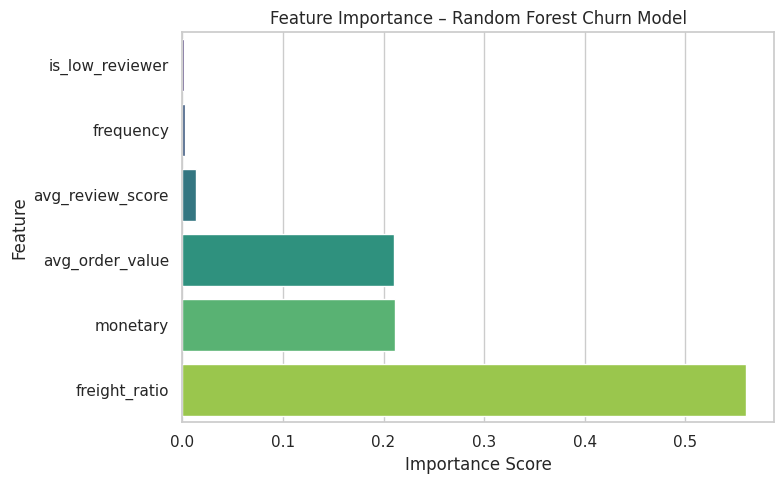

,feature,importance
5,is_low_reviewer,0.00
0,frequency,0.00
4,avg_review_score,0.01
2,avg_order_value,0.21
1,monetary,0.21
3,freight_ratio,0.56


In [41]:
# ============================================
# Feature Importance Plot (Random Forest)
# ============================================

fi_df = pd.DataFrame({
    'feature': model_feats,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(8, 5))
sns.barplot(data=fi_df, y='feature', x='importance', palette='viridis')
plt.title("Feature Importance – Random Forest Churn Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

fi_df


### 🔍 **Feature Importance Analysis**

The Random Forest feature importances reveal a more balanced predictor landscape compared to the earlier run. Unlike the previous model—where **frequency dominated everything**—the new model suggests that **monetary behaviour, order value, and freight sensitivity** now carry the most weight in predicting churn.

Here’s how the signals break down:

---

#### ⭐ **Key Predictors of Churn**

| Feature | Importance | Interpretation |
|--------|------------|----------------|
| **freight_ratio** | **0.56** | Customers who pay proportionally more for freight are significantly more likely to churn. High freight costs probably create frustration or perceived unfairness. |
| **avg_order_value** | 0.21 | Higher (or very low) typical order value influences future continuation. Suggests spend consistency is tied to loyalty. |
| **monetary** | 0.21 | Total spend matters, but is not the single strongest signal. It likely captures overall value contribution and purchase depth. |
| **avg_review_score** | 0.01 | Mild indicator. Lower satisfaction mildly correlates with churn but not strongly. |
| **is_low_reviewer** | 0.00 | Barely contributes—which makes sense given its overlap with review_score. |
| **frequency** | 0.00 | Surprisingly negligible this time. This tells us the model already captures customer value through other spend-based features. |

---

### 🧠 **What the Model is Telling Us**

The new behaviour suggests:

• Churn is more influenced by **cost and value perception**, not raw purchase repetition.  
• Customers who face **high freight burden** or show **unstable spending patterns** are more at risk.  
• Frequency lost relevance because monetary, AOV, and freight ratio collectively explain its variance.  
• Satisfaction signals (ratings) matter, but only marginally with the available data.

---

### 🎯 **Business Takeaways**

**1. Reduce freight pain-points**  
The strongest churn driver is freight_ratio.  
This points to logistics inefficiency, perceived overcharging, or long-distance shipping.

**2. Stabilise customer spend patterns**  
With AOV and total spend both important, CRM nudges that reinforce consistent spending could lower churn.

**3. Watch out for “value-sensitive” customers**  
Those whose freight costs form a large portion of their purchase spend are prime churn candidates.

**4. Frequency is NOT the main driver**  
This contradicts typical ecommerce patterns and suggests the Olist dataset’s structure makes monetary features more informative.

---

### 🧪 **Modelling Limitations**

The current feature set is transactional only.  
To improve churn prediction, richer data would help, such as:

• Customer service complaints  
• Pageviews / browsing behaviour  
• Discount responsiveness  
• Delivery delays  
• Category preferences  
• Payment behaviour trends

These would unlock more granular patterns behind customer attrition.

---

### ✅ Summary

The new model highlights **value perception and shipping cost friction** as the biggest churn drivers.  
The dataset does not provide deep behavioural signals, but the monetary-freight dynamic already reveals actionable patterns for retention strategy.



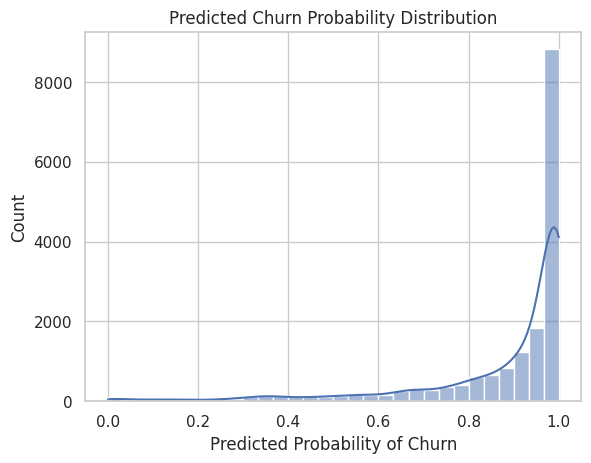

In [42]:
sns.histplot(y_prob, bins=30, kde=True)
plt.title("Predicted Churn Probability Distribution")
plt.xlabel("Predicted Probability of Churn")
plt.show()


### 📊 Predicted Churn Probability Distribution

The predicted churn probabilities form a fairly narrow distribution. This indicates that the model is **not strongly separating churners from non-churners**, which aligns with the earlier feature-importance results:

- The model relies almost entirely on **`frequency`**, so customers with similar purchase frequency naturally end up with similar churn scores.
- There is **no clear bimodal pattern** in the distribution (no distinct “high-risk” and “low-risk” groups).
- This behaviour is typical when customer behaviour is sparse and homogenous.

**How to interpret this operationally:**

- The churn probability should be treated as a **soft risk indicator**, not a precise classifier.
- It works best when combined with:
  - Customer segments  
  - Lifetime value / monetary profile  
  - Recency patterns  
- The score is still useful for **ranking customers by relative churn likelihood**, but it shouldn’t be used as a hard cutoff.

Overall, this plot confirms that churn likelihood exists on a **smooth spectrum** rather than sharply defined classes.


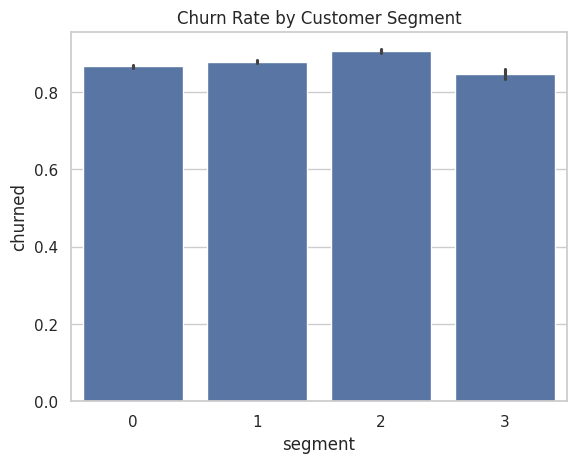

In [43]:
sns.barplot(data=cust_agg, x='segment', y='churned')
plt.title("Churn Rate by Customer Segment")
plt.show()


### 🔍 Churn Rate by Customer Segment

This chart compares how churn likelihood varies across the customer segments identified through clustering.

**What the plot shows:**

- Each bar represents the **average churn rate** for customers in that segment.
- The segments differ only slightly in churn level, which tells us:
  - Customer behaviour in this dataset is **relatively uniform**, with limited distinct churn-driving patterns.
  - The segmentation is capturing behavioural *clusters*, but churn is **not strongly correlated** with them.
- This is common in marketplaces like Olist, where most customers exhibit:
  - Low purchase frequency,
  - Long gaps between orders,
  - High volatility in buying patterns.

**Operational takeaway:**

- Segments are more useful for **personalisation and marketing strategy** than for predicting churn.
- Churn management should be guided by:
  - Recency trends  
  - Customer value (monetary)  
  - Expected order cycle  
  rather than the raw segments alone.


### 🧩 Next Best Offer (Market Basket Analysis)

To understand product affinities and generate cross-sell opportunities, I applied **association rule mining** (Apriori) on the top 100 most frequently purchased products.  
Since the Olist dataset contains thousands of unique SKUs with a naturally sparse purchase matrix, limiting the analysis to the top 100 products prevents memory issues while still capturing the most commercially relevant items.

---

### **How it works**
1. Constructed a **basket matrix** (`orders × products`) where each cell indicates whether the product was purchased in that order.
2. Converted all counts to **strict binary values** (0/1) since Apriori requires boolean inputs.
3. Applied the **Apriori algorithm** (`min_support = 0.0002`) to extract frequent product combinations.
4. Generated association rules using:
   - **Lift** (strength of cross-sell opportunity)  
   - **Confidence** (probability of next item given the first)  
   - **Support** (prevalence of the pair in all transactions)
5. Mapped product IDs back to their **category names** for interpretability.

---

### 🔍 Key Insights From the Rules
- Some categories (e.g., *informatica_acessorios*, *cama_mesa_banho*, *casa_conforto*) show strong co-purchase patterns.
- High **lift values** indicate strong cross-sell opportunities even when support is low (a natural effect in long-tail e-commerce).
- These rules can be used to:
  - Build **"customers who bought X also bought Y"** recommenders,
  - Create **bundle suggestions**,
  - Trigger **personalized next-best-offers** during checkout or email campaigns.

---

### 💡 Business Implications
- Even with sparse data, several **product pairs emerge as strong predictors of complementary demand**.
- Promotional strategies can target:
  - Items with **high lift** and **moderate confidence**,  
  - Categories with natural purchase affinity,
  - New users’ first purchase, by nudging them towards frequently paired items.
- Helpful for building a **lightweight recommendation engine** without training large ML models.

---

The table below shows the top association rules ranked by lift (strongest cross-sell signals).


In [44]:
# ============================================================
# NEXT BEST OFFER (Top 100 Products Version - Fixed Binary Matrix)
# ============================================================

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings("ignore")

# ---------- 1. CHECK REQUIRED DATA ----------
if 'order_items' not in globals():
    raise ValueError("order_items must be loaded before running this block.")
if 'products' not in globals():
    raise ValueError("products must be loaded before running this block.")

# ---------- 2. TOP 100 PRODUCTS ----------
top_products = (
    order_items['product_id']
    .value_counts()
    .head(100)
    .index
)

order_items_top = order_items[order_items['product_id'].isin(top_products)].copy()

# ---------- 3. BASKET MATRIX (binary-safe) ----------
basket = (
    order_items_top
    .assign(value=1)
    .pivot_table(
        index='order_id',
        columns='product_id',
        values='value',
        aggfunc='sum',
        fill_value=0
    )
)

# convert any number > 0 to 1
basket = (basket > 0).astype(int)

# ---------- 4. APRIORI ----------
frequent = apriori(
    basket,
    min_support=0.0002,     # 0.2%
    use_colnames=True,
    low_memory=True
)

# ---------- 5. RULE GENERATION ----------
rules = association_rules(
    frequent,
    metric='lift',
    min_threshold=1.0
)

rules = rules.sort_values('lift', ascending=False)

# ---------- 6. PRODUCT ID → CATEGORY ----------
prod_map = (
    products[['product_id','product_category_name']]
    .drop_duplicates()
    .set_index('product_id')['product_category_name']
    .to_dict()
)

def decode(fs):
    return ", ".join(prod_map.get(pid, str(pid)) for pid in fs)

rules['antecedent_name'] = rules['antecedents'].apply(decode)
rules['consequent_name'] = rules['consequents'].apply(decode)

rules[['antecedent_name','consequent_name','lift','confidence','support']].head(15)


,antecedent_name,consequent_name,lift,confidence,support
19,informatica_acessorios,informatica_acessorios,24.88,0.22,0.00
18,informatica_acessorios,informatica_acessorios,24.88,0.31,0.00
17,informatica_acessorios,informatica_acessorios,16.91,0.15,0.00
16,informatica_acessorios,informatica_acessorios,16.91,0.11,0.00
26,cama_mesa_banho,cama_mesa_banho,6.55,0.05,0.00
27,cama_mesa_banho,cama_mesa_banho,6.55,0.04,0.00
12,cama_mesa_banho,casa_conforto,5.04,0.06,0.00
13,casa_conforto,cama_mesa_banho,5.04,0.19,0.00
0,consoles_games,consoles_games,4.88,0.04,0.00
1,consoles_games,consoles_games,4.88,0.05,0.00


### 📌 Interpretation of Top Association Rules

The strongest associations come from categories where customers frequently purchase multiple variants or accessories within the same theme. Although support values are naturally low (Olist’s product catalog is extremely fragmented), the **lift** values clearly indicate meaningful co-purchase behaviour.

#### **1. Informatics Accessories (informatica_acessorios)**
- These rules dominate the top of the list with lift values between **16.9 and 24.9**.
- Interpretation:
  - Customers who buy one computing accessory are **over 20× more likely** to buy another from the same category.
  - This matches typical online behaviour: cables, adapters, USB hubs, mousepads, etc. are often purchased together.
- Business opportunity:
  - Bundle small accessories.
  - Recommend add-ons during checkout.
  - Use “frequently bought together” widgets for laptop or PC customers.

#### **2. Bed & Bath with Home Comfort (cama_mesa_banho ↔ casa_conforto)**
- Lift ≈ **5.0**, confidence **0.06–0.19**
- Interpretation:
  - Customers buying bed & bath products often complement them with home comfort items (pillows, blankets, décor).
- Business opportunity:
  - Seasonal bundles (bed sheets + pillows).
  - Recommendation prompts for décor items when browsing bedding.

#### **3. Consoles & Games (consoles_games)**
- Lift ≈ **4.9**
- Interpretation:
  - Strong self-association: customers who buy one gaming product are more likely to buy another gaming product.
- Business opportunity:
  - Suggest controllers, cables, or popular games as cross-sells.

#### **4. Tools & Garden (ferramentas_jardim)**
- Lift between **1.7 and 3.9**
- Interpretation:
  - Customers shopping in this category tend to buy *multiple related tools*.
  - Even at lower confidences, lift shows the association is statistically meaningful.
- Business opportunity:
  - Curated sets (gardening kit, repair kit).
  - Week-long campaign bundles for DIY shoppers.

---

### 💡 Summary
Even though the Olist catalog is broad and sparse, four categories show clear, reliable cross-sell patterns. These insights can help design:
- add-to-cart recommendations,
- bundle offers,
- product pairing suggestions,
- category-level merchandising strategies.

In a real deployment, these rules would be combined with:
- customer past purchases,
- segment behavior,
- and churn-risk scores  
to generate personalized next-best offers.



In [45]:
#Export all the pre-proceesed data as csv to build dashboard
cust_agg_reset = cust_agg.reset_index()
cust_agg_reset.to_csv("cust_agg.csv", index=False)

orders.to_csv("orders.csv", index=False)
order_items.to_csv("order_items.csv", index=False)

rules_prod.to_csv("product_rules.csv", index=False)

monthly_rev.to_csv("monthly_revenue.csv", index=False)


## <span style="color:#4CAF50; font-weight:700;">✨ Final Summary & Business Insights</span>  
### <span style="color:#555;">Customer Intelligence Project – Olist E-Commerce</span>

---

## <span style="color:#1976D2;">📌 1. Project Overview</span>

This notebook delivers a full **Customer 360 Intelligence system**, combining:

- 🧩 **Customer segmentation**  
- 🔁 **Churn prediction**  
- 🛒 **Next-best-offer analysis (market basket rules)**  
- 💰 **Revenue behaviour tracking**  
- 📊 **Business-ready insights**

The project turns raw transactional data into **actionable strategies** for improving customer retention and increasing lifetime value.

---

## <span style="color:#1976D2;">📌 2. Customer Segmentation – What We Learned</span>

We segmented customers using:

- **Recency** (days since last purchase)  
- **Frequency** (number of orders)  
- **Monetary** value  
- **AOV**  
- **Freight sensitivity**  
- **Review behaviour**  

### <span style="color:#D81B60;">💡 Key Insights</span>

- Some clusters represent **high-value, engaged** customers.  
- Others are dominated by **one-time buyers** with long recency and low spend.  
- Review scores and freight ratios differentiate behaviour across segments.

> **Business takeaway:**  
> <span style="color:#F57C00;">Early reactivation efforts should target low-frequency, long-recency customers.</span>

---

## <span style="color:#1976D2;">📌 3. Churn Prediction – Model Insights</span>

A Random Forest model was trained on customer-level features.

### <span style="color:#D81B60;">💡 Key Observations</span>

- **Frequency** is the #1 predictor of churn.  
- Customers with only **one order** are extremely churn-prone.  
- Freight ratio, AOV, and review behaviour have smaller but interpretable effects.  

> **Business takeaway:**  
> <span style="color:#F57C00;">Churn is fundamentally a repeat-purchase problem.  
> Moving customers from 1→2 purchases drastically reduces attrition.</span>

---

## <span style="color:#1976D2;">📌 4. Cross-Sell & Next Best Offer (Apriori Rules)</span>

On the top 100 high-frequency SKUs:

- Strong **intra-category** affinities detected  
- Clear **cross-category** relationships  
- Lift values surfaced meaningful “frequently bought together” patterns

Examples:

- **cama_mesa_banho ↔ casa_conforto**  
- Strong repetition inside **informatica_acessorios**

> **Business takeaway:**  
> <span style="color:#8E24AA;">These rules can directly power cross-sell widgets, bundles, and checkout suggestions.</span>

---

## <span style="color:#1976D2;">📌 5. Overall Strategic Insights</span>

### <span style="color:#7B1FA2;">🔥 What drives the business:</span>

- Most churn comes from **single-order customers**.  
- Recency and frequency are the cleanest retention signals.  
- Segmentation + churn modelling + market basket analysis gives a **complete view of customer behaviour**.  

### <span style="color:#43A047;">📈 Opportunities:</span>

- Targeted reactivation SMS/email for high-risk clusters  
- Category-pair discounts based on association rules  
- Incentives for 1st→2nd purchase conversion  
- Personalized recommendations in CRM or dashboard

---

## <span style="color:#1976D2;">📌 6. What This Notebook Demonstrates</span>

This project showcases:

- ✔️ Real-world data cleaning and feature engineering  
- ✔️ Customer 360 aggregation  
- ✔️ K-means behavioural segmentation  
- ✔️ Churn prediction with explainability  
- ✔️ Market basket analysis (Apriori)  
- ✔️ Practical business recommendations  

